# E-Commerce Fraud Detection

This project models E-Commerce transaction data to identify fraudelent activity, based on this [Kaggle Dataset](https://www.kaggle.com/datasets/umuttuygurr/e-commerce-fraud-detection-dataset). The dataset is synthetic, but very realistic, as it is modeled after real-life fraudulent activity observed in 2024, with scenarios such as
- Cards tested with $1 purchases at midnight
- Transactions that shipped “gaming accessories” 5,000 km away
- Promo codes being reused from freshly created accounts.

I decided to focus on this dataset as it is the most complete, realistic data on transaction fraud that I could find. Other fraud datasets that weren't synthetic had to obfuscate the meaning of features and their values for privacy reasons, using techniques like PCA, so features had meaningless names like V1, V2, etc.

Here is a list of the columns in the dataset with brief descriptions:

- `transaction_id`: Unique transaction identifier
- `user_id`: User identifier (each user 40–60 transactions)
- `account_age_days`: Age of user account in days
- `total_transactions_user`: Number of transactions per user
- `avg_amount_user`: User’s mean transaction amount
- `amount`: Transaction amount (USD)
- `country`: User’s country
- `bin_country`: Country of the card-issuing bank
- `channel`: “web” or “app”
- `merchant_category`: Type of purchase: electronics, fashion, grocery, gaming, travel
- `promo_used`: whether a discount/promo was used
- `avs_flag`: Address Verification result, a mismatch in the billing address provided by a customer and the one on file with their card issuer.
- `cvv_result`: CVV code match result, indicates if 3 digit code on back of card provided during an online transaction matched the card issuer's records
- `three_ds_flag`: 3D Secure enabled, so if a transaction is flagged, it prompts the customer to complete an extra verification step, such as a one-time code sent to your phone, a password, or biometric login
- `transaction_time`: Transaction timestamp (UTC)
- `shipping_distance_km`: Distance between billing and shipping addresses
- `is_fraud`: Target label (1 = fraud, 0 = normal)

## Setup
### Define parameters
The input/output parameters are defined in the next cell.

In [23]:
# Data input parameters
kaggle_source = "umuttuygurr/e-commerce-fraud-detection-dataset"
data_dir = "./data"
csv_file = "transactions.csv"
# Column definitions
target_col = "is_fraud"
id_cols = ['transaction_id', 'user_id']
date_feature = 'transaction_time'
# Define categorical features (including binary flags)
categorical_features = ['country', 'bin_country', 'channel', 'merchant_category', 
                       'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']
# Define numeric features (continuous/count variables only)
numeric_features = ['account_age_days', 'total_transactions_user', 'avg_amount_user', 
                   'amount', 'shipping_distance_km']
# Validation/Test split ratios
val_ratio = .2
test_ratio = .2

# Prepend this string to final answers so they print as bold text
BOLD = "\033[1m"

### Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score, roc_auc_score, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb

### Define functions

In [ ]:
def download_data_csv(kaggle_source, data_dir, csv_file):
    """Download csv file from kaggle_source. Requires install of kaggle python
    package to use the Kaggle API and Kaggle API credentials set up in
    `~/.kaggle/kaggle.json`. Creates data directory, data_dir, if it doesn't
    exist. csv_file is the name of the downloaded file.
    """
    Path(data_dir).mkdir(parents=True, exist_ok=True)
    if not os.path.exists(f"{data_dir}/{csv_file}"):
        print(f"\nDownloading dataset from Kaggle...")
        !kaggle datasets download -d {kaggle_source} -p {data_dir} --unzip
        print("Download complete!")
    else:
        print(f"\nDataset already exists at {data_dir}/{csv_file}")

def load_data(data_dir, csv_file, verbose=True):
    df = pd.read_csv(
        f"{data_dir}/{csv_file}",
        low_memory=False  # Read entire file to infer dtypes properly
    )
    if verbose:
        print(f"\nDataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
        print(f"\nMemory Usage:\n{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    return df
    
def plot_target_distribution(df, target_col):
    # Visualize target variable distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Count plot
    df[target_col].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
    axes[0].set_title('Target Variable Distribution (Count)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Is Fraud')
    axes[0].set_ylabel('Count')
    axes[0].set_xticklabels(['Normal (0)', 'Fraud (1)'], rotation=0)
    
    # Percentage plot
    df[target_col].value_counts(normalize=True).plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
    axes[1].set_title('Target Variable Distribution (Percentage)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Is Fraud')
    axes[1].set_ylabel('Percentage')
    axes[1].set_xticklabels(['Normal (0)', 'Fraud (1)'], rotation=0)
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    
    plt.tight_layout()
    plt.show()
    
def analyze_target_stats(df, target_col):
    # Target distribution
    target_dist = df[target_col].value_counts(normalize=True)
    print("\nTarget Distribution (%):")
    print(target_dist * 100)
    # Check class imbalance
    target_vals = target_dist.values
    target_ratio = target_vals[0] / target_vals[1]
    if target_ratio > 10:
        print(f"\n{BOLD}Warning: Large class imbalance ({target_ratio:.1f}) detected!\n")
    else:
        print(f"\nClass imbalance = {target_ratio:.1f}\n")
    plot_target_distribution(df, target_col)

def analyze_feature_stats(df, id_cols, target_col, categorical_features, numeric_features):
    # Summary for categorical/object columns
    print(f"\nCategorical Features ({len(categorical_features)}): {categorical_features}")
    if len(categorical_features) > 0:
        print("\nCategorical Features Summary:")
        for col in categorical_features:
            print(f"\n{col}:")
            print(f"  Unique values: {df[col].nunique()}")
            print(f"  Top 5 values:\n{df[col].value_counts().head()}")

    # Statistical summary for numerical columns
    print(f"\n\nNumeric Features ({len(numeric_features)}): {numeric_features}")
    print("\nNumeric Features Summary:")
    display(df[numeric_features].describe())
        
def split_train_val_test(df, val_ratio=.2, test_ratio=.2, stratify=None, r_seed=1, verbose=False):
    """Use the train_test_split function from sklearn to split input dataframe
    into randomly shuffled train, validation, and test datasets with the
    validation dataset containing val_ratio of the input data and the test
    dataset containing test_ratio of the input data. Stratify, if provided, is 
    the name of the column in df to use when stratifying the splits.
    """
    n = len(df)
    # Generate test dataset
    strat_col = stratify
    if stratify:
        strat_col = df[stratify]
    full_train_df, test_df = train_test_split(df, test_size=test_ratio, stratify=strat_col, random_state=r_seed)
    test_df = test_df.reset_index(drop=True)
    # Generate train, validation, and test splits
    val_ft_ratio = val_ratio / (1 - test_ratio)
    if stratify:
        strat_col = full_train_df[stratify]
    train_df, val_df = train_test_split(full_train_df, test_size=val_ft_ratio, stratify=strat_col, random_state=r_seed)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    if verbose:
        print(f"All rows in the original dataframe are contained within the training, validation, or test datasets: {len(train_df) + len(val_df) + len(test_df) == len(df)}")
        print(f"\nTrain set: {len(train_df)} rows ({len(train_df)/len(df)*100:.1f}%)")
        print(f"Validation set: {len(val_df)} rows ({len(val_df)/len(df)*100:.1f}%)")
        print(f"Test set: {len(test_df)} rows ({len(test_df)/len(df)*100:.1f}%)")
    return train_df, val_df, test_df

def calculate_mi_scores(df, categorical_features, target_col):
    """Calculate mutual information scores for categorical and ordinal features."""
    mi_scores = []
    for feature in categorical_features:
        score = mutual_info_score(df[feature], df[target_col])
        mi_scores.append({'feature': feature, 'mi_score': score})
    mi_df = pd.DataFrame(mi_scores).sort_values('mi_score', ascending=False).reset_index(drop=True)
    return mi_df

def calculate_numeric_correlations(df, numeric_features, target_col):
    """Calculate Pearson correlations for numeric features with target."""
    correlations = []
    for feature in numeric_features:
        corr = df[feature].corr(df[target_col])
        correlations.append({'feature': feature, 'correlation': corr, 'abs_correlation': abs(corr)})
    corr_df = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False).reset_index(drop=True)
    return corr_df[['feature', 'correlation']]

def calculate_vif(df, numeric_features):
    """Calculate Variance Inflation Factor for numeric features."""
    X = df[numeric_features].values
    vif_data = []
    for i, feature in enumerate(numeric_features):
        vif = variance_inflation_factor(X, i)
        vif_data.append({'feature': feature, 'VIF': vif})
    vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False).reset_index(drop=True)
    return vif_df

# ============ EDA FUNCTIONS ============

def plot_numeric_distributions(df, numeric_features):
    """Visualize distributions of numeric features with histograms."""
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_features):
        ax = axes[idx]
        df[col].hist(bins=50, ax=ax, alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_title(f'Distribution of {col}', fontsize=11, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        
        mean_val = df[col].mean()
        median_val = df[col].median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
        ax.legend()
    
    if len(numeric_features) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
    print("\nKey Observations:")
    print("- 'amount' and 'avg_amount_user' are right-skewed (consider log transformation)")
    print("- 'shipping_distance_km' shows wide variation (potential outliers)")
    print("- 'account_age_days' appears relatively uniform")
    print("- 'total_transactions_user' clusters around 50 transactions")

def analyze_vif(df, numeric_features):
    """Calculate and visualize VIF for multicollinearity detection."""
    vif_df = calculate_vif(df, numeric_features)
    print("Variance Inflation Factor (VIF) Analysis:")
    print("=" * 50)
    print(vif_df.to_string(index=False))
    print("\n" + "=" * 50)
    print("\nInterpretation:")
    print("- VIF < 5: Low multicollinearity (acceptable)")
    print("- VIF 5-10: Moderate multicollinearity (monitor)")
    print("- VIF > 10: High multicollinearity (consider removing)")
    
    plt.figure(figsize=(10, 5))
    plt.barh(vif_df['feature'], vif_df['VIF'], color='coral', edgecolor='black')
    plt.xlabel('VIF Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Variance Inflation Factor (VIF) - Multicollinearity Check', fontsize=13, fontweight='bold')
    plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5 (Moderate)')
    plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 10 (High)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\nKey Findings:")
    if vif_df['VIF'].max() > 10:
        high_vif = vif_df[vif_df['VIF'] > 10]['feature'].tolist()
        print(f"- High multicollinearity detected in: {high_vif}")
        print("- Consider removing or combining these features")
    elif vif_df['VIF'].max() > 5:
        print("- Moderate multicollinearity present but generally acceptable")
    else:
        print("- All features show low multicollinearity")
    
    return vif_df

def analyze_correlations(df, numeric_features, target_col):
    """Calculate and visualize correlations with target variable."""
    corr_df = calculate_numeric_correlations(df, numeric_features, target_col)
    print("Pearson Correlation with Target (is_fraud):")
    print("=" * 60)
    print(corr_df.to_string(index=False))
    print("=" * 60)
    
    plt.figure(figsize=(10, 5))
    colors = ['green' if x > 0 else 'red' for x in corr_df['correlation']]
    plt.barh(corr_df['feature'], corr_df['correlation'], color=colors, edgecolor='black')
    plt.xlabel('Correlation Coefficient', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Correlation of Numeric Features with Fraud Target', fontsize=13, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.tight_layout()
    plt.show()
    
    print("\nKey Insights:")
    print("- Positive correlation: Higher values associated with fraud")
    print("- Negative correlation: Lower values associated with fraud")
    print("- Values closer to ±1 indicate stronger linear relationships")
    
    return corr_df

def plot_box_plots(df, numeric_features, target_col):
    """Compare feature distributions between fraud and non-fraud using box plots."""
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_features):
        ax = axes[idx]
        df.boxplot(column=col, by=target_col, ax=ax, patch_artist=True)
        ax.set_title(f'{col} by Fraud Status', fontsize=11, fontweight='bold')
        ax.set_xlabel('Is Fraud')
        ax.set_ylabel(col)
        ax.set_xticklabels(['Normal', 'Fraud'])
        plt.sca(ax)
        plt.xticks([1, 2], ['Normal (0)', 'Fraud (1)'])
    
    if len(numeric_features) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.suptitle('')
    plt.tight_layout()
    plt.show()
    
    print("\nBox Plot Interpretation:")
    print("- Look for differences in medians (center line) between fraud and non-fraud")
    print("- Different distributions suggest the feature is discriminative")
    print("- Overlapping boxes indicate less predictive power")

def analyze_temporal_patterns(df, date_feature, target_col, baseline_fraud_rate):
    """Analyze and visualize fraud patterns over time."""
    # Extract temporal features
    df['hour'] = df[date_feature].dt.hour
    df['day_of_week'] = df[date_feature].dt.dayofweek
    df['month'] = df[date_feature].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Hour of day
    ax = axes[0, 0]
    hourly_fraud = df.groupby('hour')[target_col].mean()
    hourly_fraud.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
    ax.axhline(y=baseline_fraud_rate, color='red', linestyle='--', linewidth=2, label='Baseline')
    ax.set_title('Fraud Rate by Hour of Day', fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Fraud Rate')
    ax.legend()
    
    # Day of week
    ax = axes[0, 1]
    dow_fraud = df.groupby('day_of_week')[target_col].mean()
    dow_fraud.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
    ax.axhline(y=baseline_fraud_rate, color='red', linestyle='--', linewidth=2, label='Baseline')
    ax.set_title('Fraud Rate by Day of Week', fontsize=12, fontweight='bold')
    ax.set_xlabel('Day of Week (0=Monday, 6=Sunday)')
    ax.set_ylabel('Fraud Rate')
    ax.legend()
    
    # Month
    ax = axes[1, 0]
    monthly_fraud = df.groupby('month')[target_col].mean()
    monthly_fraud.plot(kind='bar', ax=ax, color='lightgreen', edgecolor='black')
    ax.axhline(y=baseline_fraud_rate, color='red', linestyle='--', linewidth=2, label='Baseline')
    ax.set_title('Fraud Rate by Month', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel('Fraud Rate')
    ax.legend()
    
    # Weekend vs Weekday
    ax = axes[1, 1]
    weekend_fraud = df.groupby('is_weekend')[target_col].mean()
    weekend_fraud.plot(kind='bar', ax=ax, color='orchid', edgecolor='black')
    ax.axhline(y=baseline_fraud_rate, color='red', linestyle='--', linewidth=2, label='Baseline')
    ax.set_title('Fraud Rate: Weekday vs Weekend', fontsize=12, fontweight='bold')
    ax.set_xlabel('Is Weekend')
    ax.set_ylabel('Fraud Rate')
    ax.set_xticklabels(['Weekday (0)', 'Weekend (1)'], rotation=0)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\nTemporal Insights:")
    print(f"- Peak fraud hour: {hourly_fraud.idxmax()} (fraud rate: {hourly_fraud.max():.4f})")
    print(f"- Safest hour: {hourly_fraud.idxmin()} (fraud rate: {hourly_fraud.min():.4f})")
    print(f"- Weekend fraud rate: {weekend_fraud[1]:.4f}")
    print(f"- Weekday fraud rate: {weekend_fraud[0]:.4f}")
    
    high_risk_hours = hourly_fraud[hourly_fraud > baseline_fraud_rate * 1.2]
    if not high_risk_hours.empty:
        print(f"\n⚠️  High-risk hours (>20% above baseline):")
        for hour, rate in high_risk_hours.items():
            print(f"   - Hour {hour}: {rate:.4f} fraud rate ({rate/baseline_fraud_rate:.1f}x baseline)")

def analyze_categorical_fraud_rates(df, categorical_features, target_col):
    """Analyze fraud rates for each categorical feature."""
    print("Fraud Rates by Categorical Features")
    print("=" * 80)
    
    for feature in categorical_features:
        print(f"\n{feature.upper()}:")
        print("-" * 80)
        
        fraud_rate = df.groupby(feature)[target_col].agg(['sum', 'count', 'mean']).reset_index()
        fraud_rate.columns = [feature, 'fraud_count', 'total_count', 'fraud_rate']
        fraud_rate['fraud_rate'] = fraud_rate['fraud_rate'] * 100
        fraud_rate = fraud_rate.sort_values('fraud_rate', ascending=False)
        
        print(fraud_rate.to_string(index=False))
        
        baseline_rate = df[target_col].mean() * 100
        high_risk = fraud_rate[fraud_rate['fraud_rate'] > baseline_rate * 1.5]
        if not high_risk.empty:
            print(f"\n⚠️  High-risk categories (>1.5x baseline rate of {baseline_rate:.2f}%):")
            for _, row in high_risk.iterrows():
                print(f"   - {row[feature]}: {row['fraud_rate']:.2f}% fraud rate")
    
    print("\n" + "=" * 80)

def plot_categorical_fraud_rates(df, categorical_features, target_col, baseline_fraud_rate):
    """Visualize fraud rates for categorical features."""
    fig, axes = plt.subplots(4, 2, figsize=(16, 16))
    axes = axes.flatten()
    
    for idx, feature in enumerate(categorical_features):
        ax = axes[idx]
        fraud_rate = df.groupby(feature)[target_col].mean().sort_values(ascending=False)
        fraud_rate.plot(kind='bar', ax=ax, color='coral', edgecolor='black', alpha=0.8)
        ax.axhline(y=baseline_fraud_rate, color='red', linestyle='--', linewidth=2, 
                   label=f'Baseline: {baseline_fraud_rate:.3f}')
        ax.set_title(f'Fraud Rate by {feature}', fontsize=12, fontweight='bold')
        ax.set_xlabel(feature)
        ax.set_ylabel('Fraud Rate')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization Insight:")
    print("- Categories significantly above the baseline (red line) are high-risk")
    print("- Large deviations suggest strong predictive power")

def analyze_mutual_information(df, categorical_features, target_col):
    """Calculate and visualize mutual information scores."""
    mi_df = calculate_mi_scores(df, categorical_features, target_col)
    print("\nMutual Information Scores (Categorical Features):")
    print("=" * 60)
    print(mi_df.to_string(index=False))
    print("=" * 60)
    print("\nInterpretation:")
    print("- Higher MI score = stronger association with target")
    print("- MI = 0 means no mutual dependence")
    print("- MI > 0.1 typically indicates meaningful predictive value")
    
    plt.figure(figsize=(10, 6))
    plt.barh(mi_df['feature'], mi_df['mi_score'], color='teal', edgecolor='black')
    plt.xlabel('Mutual Information Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Mutual Information: Categorical Features vs. Fraud Target', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return mi_df

def print_feature_recommendations(corr_df, mi_df, vif_df, numeric_features, categorical_features):
    """Print comprehensive feature selection recommendations."""
    print("=" * 80)
    print("FEATURE SELECTION RECOMMENDATIONS")
    print("=" * 80)
    
    print("\n📊 SUMMARY OF EDA FINDINGS:")
    print("-" * 80)
    
    print("\n1. NUMERIC FEATURES (Correlation Analysis):")
    print("   Features to KEEP (showing meaningful correlation):")
    for _, row in corr_df.head(5).iterrows():
        print(f"   ✓ {row['feature']}: {row['correlation']:.4f} correlation")
    
    print("\n2. CATEGORICAL FEATURES (Mutual Information Analysis):")
    print("   Features to KEEP (MI > 0.01):")
    high_mi_features = mi_df[mi_df['mi_score'] > 0.01]
    for _, row in high_mi_features.iterrows():
        print(f"   ✓ {row['feature']}: MI = {row['mi_score']:.4f}")
    
    print("\n3. MULTICOLLINEARITY CHECK:")
    if vif_df['VIF'].max() > 10:
        high_vif_features = vif_df[vif_df['VIF'] > 10]
        print("   ⚠️  Consider removing or combining these features:")
        for _, row in high_vif_features.iterrows():
            print(f"   - {row['feature']}: VIF = {row['VIF']:.2f}")
    else:
        print("   ✓ No severe multicollinearity detected")
    
    print("\n4. TEMPORAL PATTERNS:")
    print("   ✓ Hour of day shows fraud patterns (consider time-based features)")
    print("   ✓ Weekend/weekday distinction may be relevant")
    
    print("\n" + "=" * 80)
    print("RECOMMENDED FEATURES FOR MODELING:")
    print("=" * 80)
    
    print("\n✅ NUMERIC FEATURES (all 5):")
    for feat in numeric_features:
        print(f"   • {feat}")
    
    print("\n✅ CATEGORICAL FEATURES (all 8):")
    for feat in categorical_features:
        print(f"   • {feat}")
    
    print("\n✅ TEMPORAL FEATURES TO ENGINEER:")
    print("   • hour (from transaction_time)")
    print("   • day_of_week (from transaction_time)")
    print("   • is_weekend (derived from day_of_week)")
    print("   • is_midnight (hours 23-01)")
    
    print("\n💡 SUGGESTED FEATURE ENGINEERING:")
    print("   • country_mismatch: (country != bin_country)")
    print("   • amount_deviation: |amount - avg_amount_user|")
    print("   • amount_vs_avg_ratio: amount / avg_amount_user")
    print("   • high_risk_distance: (shipping_distance_km > threshold)")
    print("   • security_score: combination of avs_match + cvv_result + three_ds_flag")
    print("   • transaction_velocity: total_transactions_user / account_age_days")
    
    print("\n⚡ MODELING CONSIDERATIONS:")
    print("   • Use stratified sampling (class imbalance: 44:1)")
    print("   • Apply class weights or SMOTE for minority class")
    print("   • Use appropriate metrics: ROC-AUC, F1, Precision-Recall (not accuracy)")
    print("   • Consider threshold tuning for precision/recall trade-off")
    print("   • Try tree-based models (handle categorical features well)")
    
    print("\n" + "=" * 80)

## Load data

In [4]:
download_data_csv(kaggle_source, data_dir, csv_file)
input_df = load_data(data_dir, csv_file, verbose=True)


Dataset already exists at ./data/transactions.csv

Dataset Shape: 299695 rows, 17 columns

Memory Usage:
107.29 MB


In [5]:
input_df.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [6]:
# No null values
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

## Preprocessing
### Verify table grain

In [7]:
print(f"Every row is uniquely defined by transaction and user id columns: {len(input_df)==len(input_df.drop_duplicates(subset=id_cols))}")

Every row is uniquely defined by transaction and user id columns: True


### Target class balance
Target class imbalance is investigated prior to train/validation/test split because stratified splitting is necessary to handle the large class imbalance present in this dataset (only 2.2% fraud). Modeling will require techniques such as stratified sampling, class weights, appropriate metrics, etc.


Target Distribution (%):
is_fraud
0    97.793757
1     2.206243
Name: proportion, dtype: float64




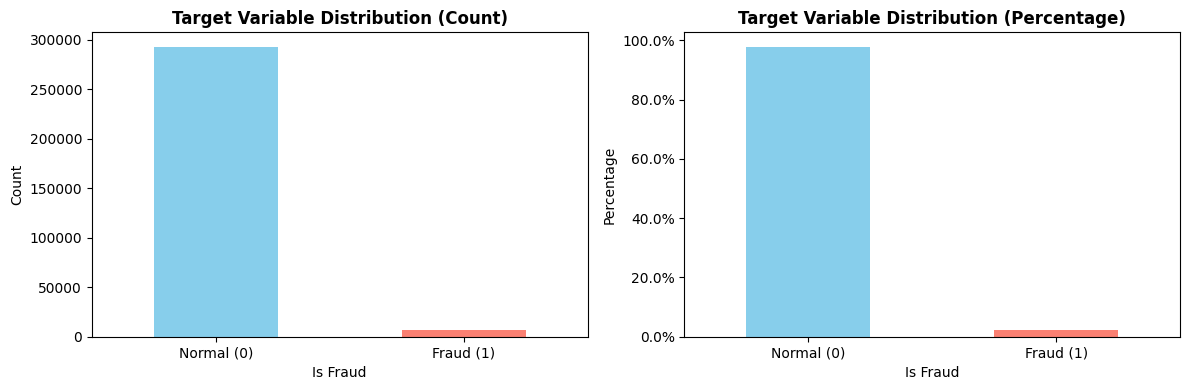

In [27]:
analyze_target_stats(input_df, target_col)

### Convert date type

In [9]:
input_df[date_feature] = pd.to_datetime(input_df[date_feature], errors='coerce')

### Feature stats
Examine the distribution of categorical features and compute summary statistics for numerical features. Binary features (0/1 flags) are treated as categorical since they represent discrete states (see Setup, Define parameters section above).

In [16]:
analyze_feature_stats(input_df, id_cols, target_col, categorical_features, numeric_features)


Categorical Features (8): ['country', 'bin_country', 'channel', 'merchant_category', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']

Categorical Features Summary:

country:
  Unique values: 10
  Top 5 values:
country
US    32430
GB    30602
FR    30343
NL    30220
TR    30074
Name: count, dtype: int64

bin_country:
  Unique values: 10
  Top 5 values:
bin_country
US    32295
GB    30563
FR    30261
NL    30256
TR    29972
Name: count, dtype: int64

channel:
  Unique values: 2
  Top 5 values:
channel
web    152226
app    147469
Name: count, dtype: int64

merchant_category:
  Unique values: 5
  Top 5 values:
merchant_category
electronics    60220
travel         59922
grocery        59913
gaming         59839
fashion        59801
Name: count, dtype: int64

promo_used:
  Unique values: 2
  Top 5 values:
promo_used
0    253650
1     46045
Name: count, dtype: int64

avs_match:
  Unique values: 2
  Top 5 values:
avs_match
1    251144
0     48551
Name: count, dtype: int64

cvv_resul

,account_age_days,total_transactions_user,avg_amount_user,amount,shipping_distance_km
count,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000
mean,973.397871,50.673321,148.142973,177.165279,357.049028
std,525.241409,5.976391,200.364624,306.926507,427.672074
min,1.000000,40.000000,3.520000,1.000000,0.000000
25%,516.000000,46.000000,46.190000,42.100000,136.600000
50%,975.000000,51.000000,90.130000,89.990000,273.020000
75%,1425.000000,56.000000,173.450000,191.110000,409.180000
max,1890.000000,60.000000,4565.290000,16994.740000,3748.560000


### Train/Validation/Test Splits

In [19]:
train_df, val_df, test_df = split_train_val_test(input_df, val_ratio=val_ratio, test_ratio=test_ratio, stratify=target_col, verbose=True)

All rows in the original dataframe are contained within the training, validation, or test datasets: True

Train set: 179817 rows (60.0%)
Validation set: 59939 rows (20.0%)
Test set: 59939 rows (20.0%)


## EDA
### Numeric features
#### Calculate baseline metrics
Define baseline fraud rate for comparison throughout EDA.

In [ ]:
# Calculate baseline fraud rate from training set
baseline_fraud_rate = train_df[target_col].mean()
print(f"Baseline fraud rate: {baseline_fraud_rate:.4f} ({baseline_fraud_rate*100:.2f}%)")
print(f"This will be used as a reference point throughout the EDA.")

#### Visualize distributions of numeric features

In [ ]:
plot_numeric_distributions(train_df, numeric_features)

#### Multicollinearity Detection (VIF)

In [ ]:
vif_df = analyze_vif(train_df, numeric_features)

### Bivariate Analysis: Features vs. Target
#### Calculate correlations with target

In [ ]:
corr_df = analyze_correlations(train_df, numeric_features, target_col)

#### Box plots: Compare feature distributions between fraud and non-fraud

In [ ]:
plot_box_plots(train_df, numeric_features, target_col)

### Temporal Analysis
Analyze fraud patterns over time to identify temporal trends.

In [ ]:
analyze_temporal_patterns(train_df, date_feature, target_col, baseline_fraud_rate)

### Categorical Features
#### Fraud Rates

In [ ]:
analyze_categorical_fraud_rates(train_df, categorical_features, target_col)

#### Visualize fraud rates for categorical features

In [ ]:
plot_categorical_fraud_rates(train_df, categorical_features, target_col, baseline_fraud_rate)

#### Calculate mutual information scores for categorical features

In [ ]:
mi_df = analyze_mutual_information(train_df, categorical_features, target_col)

### Feature Selection Recommendations

In [ ]:
print_feature_recommendations(corr_df, mi_df, vif_df, numeric_features, categorical_features)

## Feature Engineering

## Model Training